# ch 16_7 SARIMA

이번 챕터에서는 ARIMA 모델이 계절성을 반영할 수 있도록 보완한 Seasonal ARIMA에 대해서 배워보겠습니다.

In [1]:
import warnings

warnings.filterwarnings(action='ignore')

## 데이터 셋 준비

In [2]:
from utils import load_air_passengers, calculate_rmse

train_df, test_df = load_air_passengers()

<Axes: xlabel='Month'>

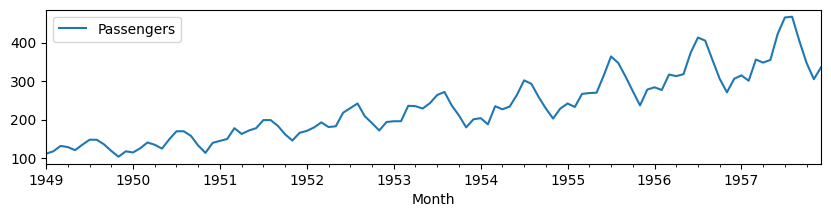

In [3]:
train_df.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

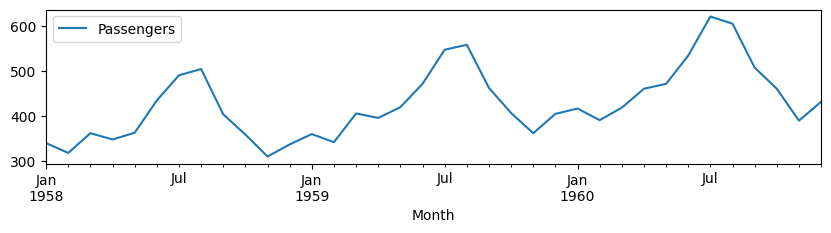

In [4]:
test_df.plot(figsize=(10, 2))

### 계절성 확인

seasonal_decompose를 이용해서 데이터 셋의 계절성을 먼저 확인해보겠습니다.

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose

additive_decomposition = seasonal_decompose(train_df['Passengers'],  model='additive')
multiplicative_decomposition = seasonal_decompose(train_df['Passengers'],  model='multiplicative')

seasonal만 따로 plot을 그려보면 12 개월 단위로 주기성을 띄는 것을 알 수 있습니다. 

<Axes: xlabel='Month'>

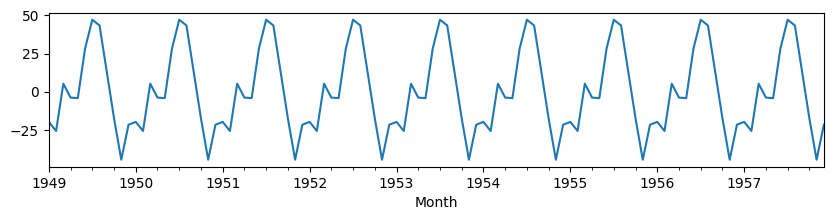

In [7]:
additive_decomposition.seasonal.plot(figsize=(10, 2))

<Axes: xlabel='Month'>

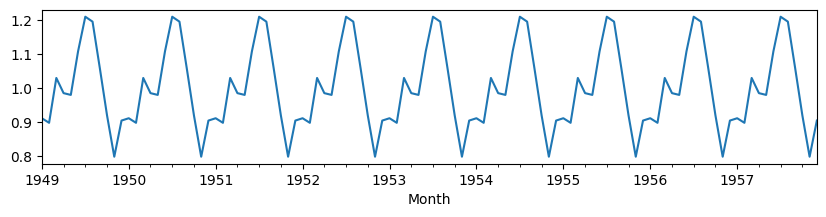

In [8]:
multiplicative_decomposition.seasonal.plot(figsize=(10, 2))

## SARIMA

데이터가 계절성을 띈다면 ARIMA 처럼 단순 차분을 적용하는 것이 적합하지 않을 수 있습니다. 이런 경우, 계절 차분을 사용하는 Seasonal ARIMA 모델을 사용할 수 있습니다.

### Seasonal Difference

바로 이전 시점의 값을 빼주는 차분과 달리 계절 차분은 이전 계절의 값을 빼주면 됩니다. 탑승객 데이터의 계절성은 12개월이라고 가정하고, 단순 차분과 계절 차분을 비교해보겠습니다.

In [9]:
train_df["diff"] = train_df["Passengers"].diff()
train_df["seasonal_diff"] = train_df["Passengers"].diff(12)

단순 차분을 할 경우, 계절성이 유지되는 모습을 확인할 수 있습니다. 반면에 계절 차분을 적용할 경우, 계절성이 제거된 것을 확인할 수 있습니다.

<Axes: xlabel='Month'>

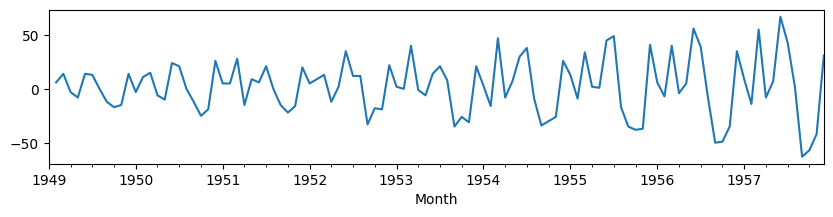

In [10]:
train_df["diff"].plot(figsize=(10, 2))

<Axes: xlabel='Month'>

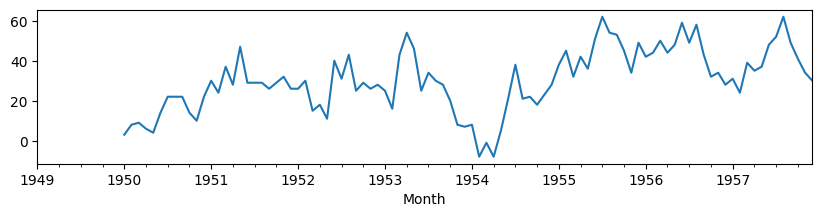

In [11]:
train_df["seasonal_diff"].plot(figsize=(10, 2))

### SARIMA

SARIMA 모델은 계절 차분을 사용하는 ARIMA 모델입니다. SARIMA는 ARIMA의 p, d, q 세 파라미터에 더해 P, D, Q 파라미터가 추가됩니다. 이는 각각 계절성을 반영한 P,  D, Q를 의미합니다.

auto_arima를 이용해서 AIRMA와 SARIMA 모델을 학습시켜보고, 결과를 비교해보겠습니다. 계절성의 주기는 12로 설정해보겠습니다.

In [12]:
from pmdarima.arima import auto_arima

arima_model = auto_arima(
    train_df["Passengers"], 
    seasonal=False, 
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.00 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.00 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.02 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.06 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.07 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.08 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=983.832, Time=0.02 sec

Best model:  ARIMA(2,1,2)(0,0,0)[0] intercept
Total fit time: 0.709 seco

In [13]:
type(arima_model)

pmdarima.arima.arima.ARIMA

In [16]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  108
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -473.609
Date:                Tue, 01 Aug 2023   AIC                            959.218
Time:                        13:15:43   BIC                            975.255
Sample:                    01-01-1949   HQIC                           965.719
                         - 12-01-1957                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.6708      0.207      3.235      0.001       0.264       1.077
ar.L1          1.6405      0.044     37.563      0.000       1.555       1.726
ar.L2         -0.9086      0.034    -26.746      0.000      -0.975      -0.842
ma.L1         -1.8338      0.047    -38.610      0.000      -1.927      -1.741
ma.L2          0.9289      0.047     19.917      0.000       0.838       1.020
sigma2       393.3179     69.406      5.667      0.000     257.286     529.350
===================================================================================
Ljung-Box (L1) (Q):                   0.59   Jarque-Bera (JB):                 3.94
Prob(Q):                              0.44   Prob(JB):                         0.14
Heteroskedasticity (H):               4.42   Skew:                             0.43
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
sarima_model = auto_arima(
    train_df["Passengers"], 
    m=12,  
    seasonal=True, 
    trace=True
)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=706.671, Time=0.92 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.730, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=704.186, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=704.801, Time=0.10 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=704.001, Time=0.01 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.472, Time=0.16 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.993, Time=0.32 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=705.691, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=705.081, Time=0.02 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=704.376, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=707.075, Time=0.06 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=705.875, Time=0.02 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.744 seconds


In [20]:
sarima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -350.001
Date:                            Tue, 01 Aug 2023   AIC                            704.001
Time:                                    13:16:17   BIC                            709.109
Sample:                                01-01-1949   HQIC                           706.065
                                     - 12-01-1957                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2411      0.091     -2.648      0.008      -0.420      -0.063
sigma2        92.7499     13.439      6.902      0.000      66.410     119.090
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 2.32
Prob(Q):                              0.92   Prob(JB):                         0.31
Heteroskedasticity (H):               0.92   Skew:                             0.38
Prob(H) (two-sided):                  0.82   Kurtosis:                         2.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

결국 auto_arima를 통해서 파라미터를 찾아서 학습시키는 모델은 statsmodels에 내장된 SARIMAX 모델입니다. SARIMAX 모델에 파라미터를 조절해서 계절성을 고려하지 않으면 ARIMA 모델이 학습되고, 계절성을 고려하면 SARIMA 모델이 학습됩니다. 외생 변수를 추가적으로 고려한 SARIMAX 모델은 다음 챕터에서 살펴보겠습니다.

### Inference
 
학습시킨 ARIMA, SARIMA 모델의 정확도를 비교하기 위해서 각각 예측값을 내려보겠습니다.

In [21]:
train_df["ARIMA"] = arima_model.predict_in_sample()
train_df["SARIMA"] = sarima_model.predict_in_sample()

In [22]:
test_df["ARIMA"] = arima_model.predict(n_periods=len(test_df))
test_df["SARIMA"] = sarima_model.predict(n_periods=len(test_df))

### Visualize

예측 값이 실제 값과 얼마나 차이가 나는지 시각화 해보겠습니다.

<Axes: xlabel='Month'>

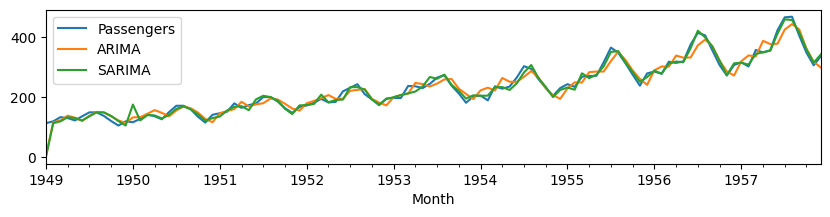

In [23]:
train_df[["Passengers", "ARIMA", "SARIMA"]].plot(figsize=(10, 2))

<Axes: xlabel='Month'>

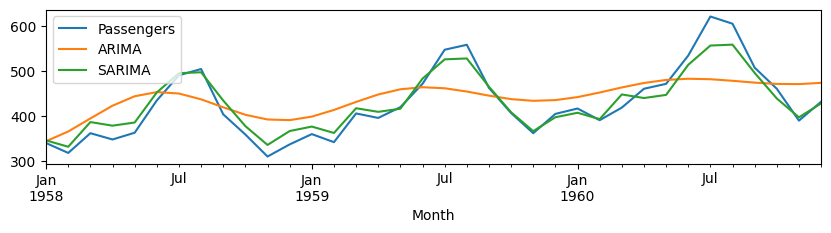

In [24]:
test_df[["Passengers", "ARIMA", "SARIMA"]].plot(figsize=(10, 2))

육안으로 보기에도 SARIMA 모델이 ARIMA 모델보다 더 정확도가 높은 것을 알 수 있습니다.

### Metric 측정

정량적으로 어느 모델이 더 정확한지 메트릭을 측정해보겠습니다.

In [25]:
calculate_rmse(test_df, "Passengers", "ARIMA")
calculate_rmse(test_df, "Passengers", "SARIMA")

ARIMA RMSE: 59.206158726932685
SARIMA RMSE: 22.132236740172


## 정리

이번 챕터에서는 ARIMA 모델에 계절성을 반영한 SARIMA 모델을 배워봤습니다. 계절성을 뚜렷하게 보여주는 Passengers 데이터에 적용해보니 명확한 성능 개선 효과를 보여주었습니다.